## Some visualisation on presets values

In [1]:
import os
import importlib

import numpy as np
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 300
#%matplotlib widget  # don't use widgets for figures to be commited
from IPython.display import Audio
import librosa
import soundfile

from synth import dexed
import data.dataset
import utils.figures


In [2]:
dexed_renderer = dexed.Dexed()
dexed_preset_db = dexed.PresetDatabase()
# Visu du dataframe de départ
presets_df = dexed_preset_db.all_presets_df

def get_preset_UID(preset_index):
    return presets_df.iloc[preset_index]['index_preset']

presets_df

,index_preset,index_cart,index_in_cartridge,name,other_names,labels,info
0,0,0,0,BRITE RDS,None,harmonic,None
1,1,0,1,BRITE.FULL,None,harmonic,None
2,2,0,2,BRITE-FULL,None,harmonic,None
3,3,0,3,BRKN WNGS1,None,"harmonic,percussive",None
4,4,0,4,BROKEROADS,None,harmonic,None
...,...,...,...,...,...,...,...
1262,393869,12529,18,Hair-kr MS,None,percussive,clamped
1263,393870,12529,19,DreamySyn,None,harmonic,None
1264,393874,12529,23,timbali,None,sfx,None
1265,393876,12529,25,PIES GLOCK,None,harmonic,None


150 free params, 5 params should be locked


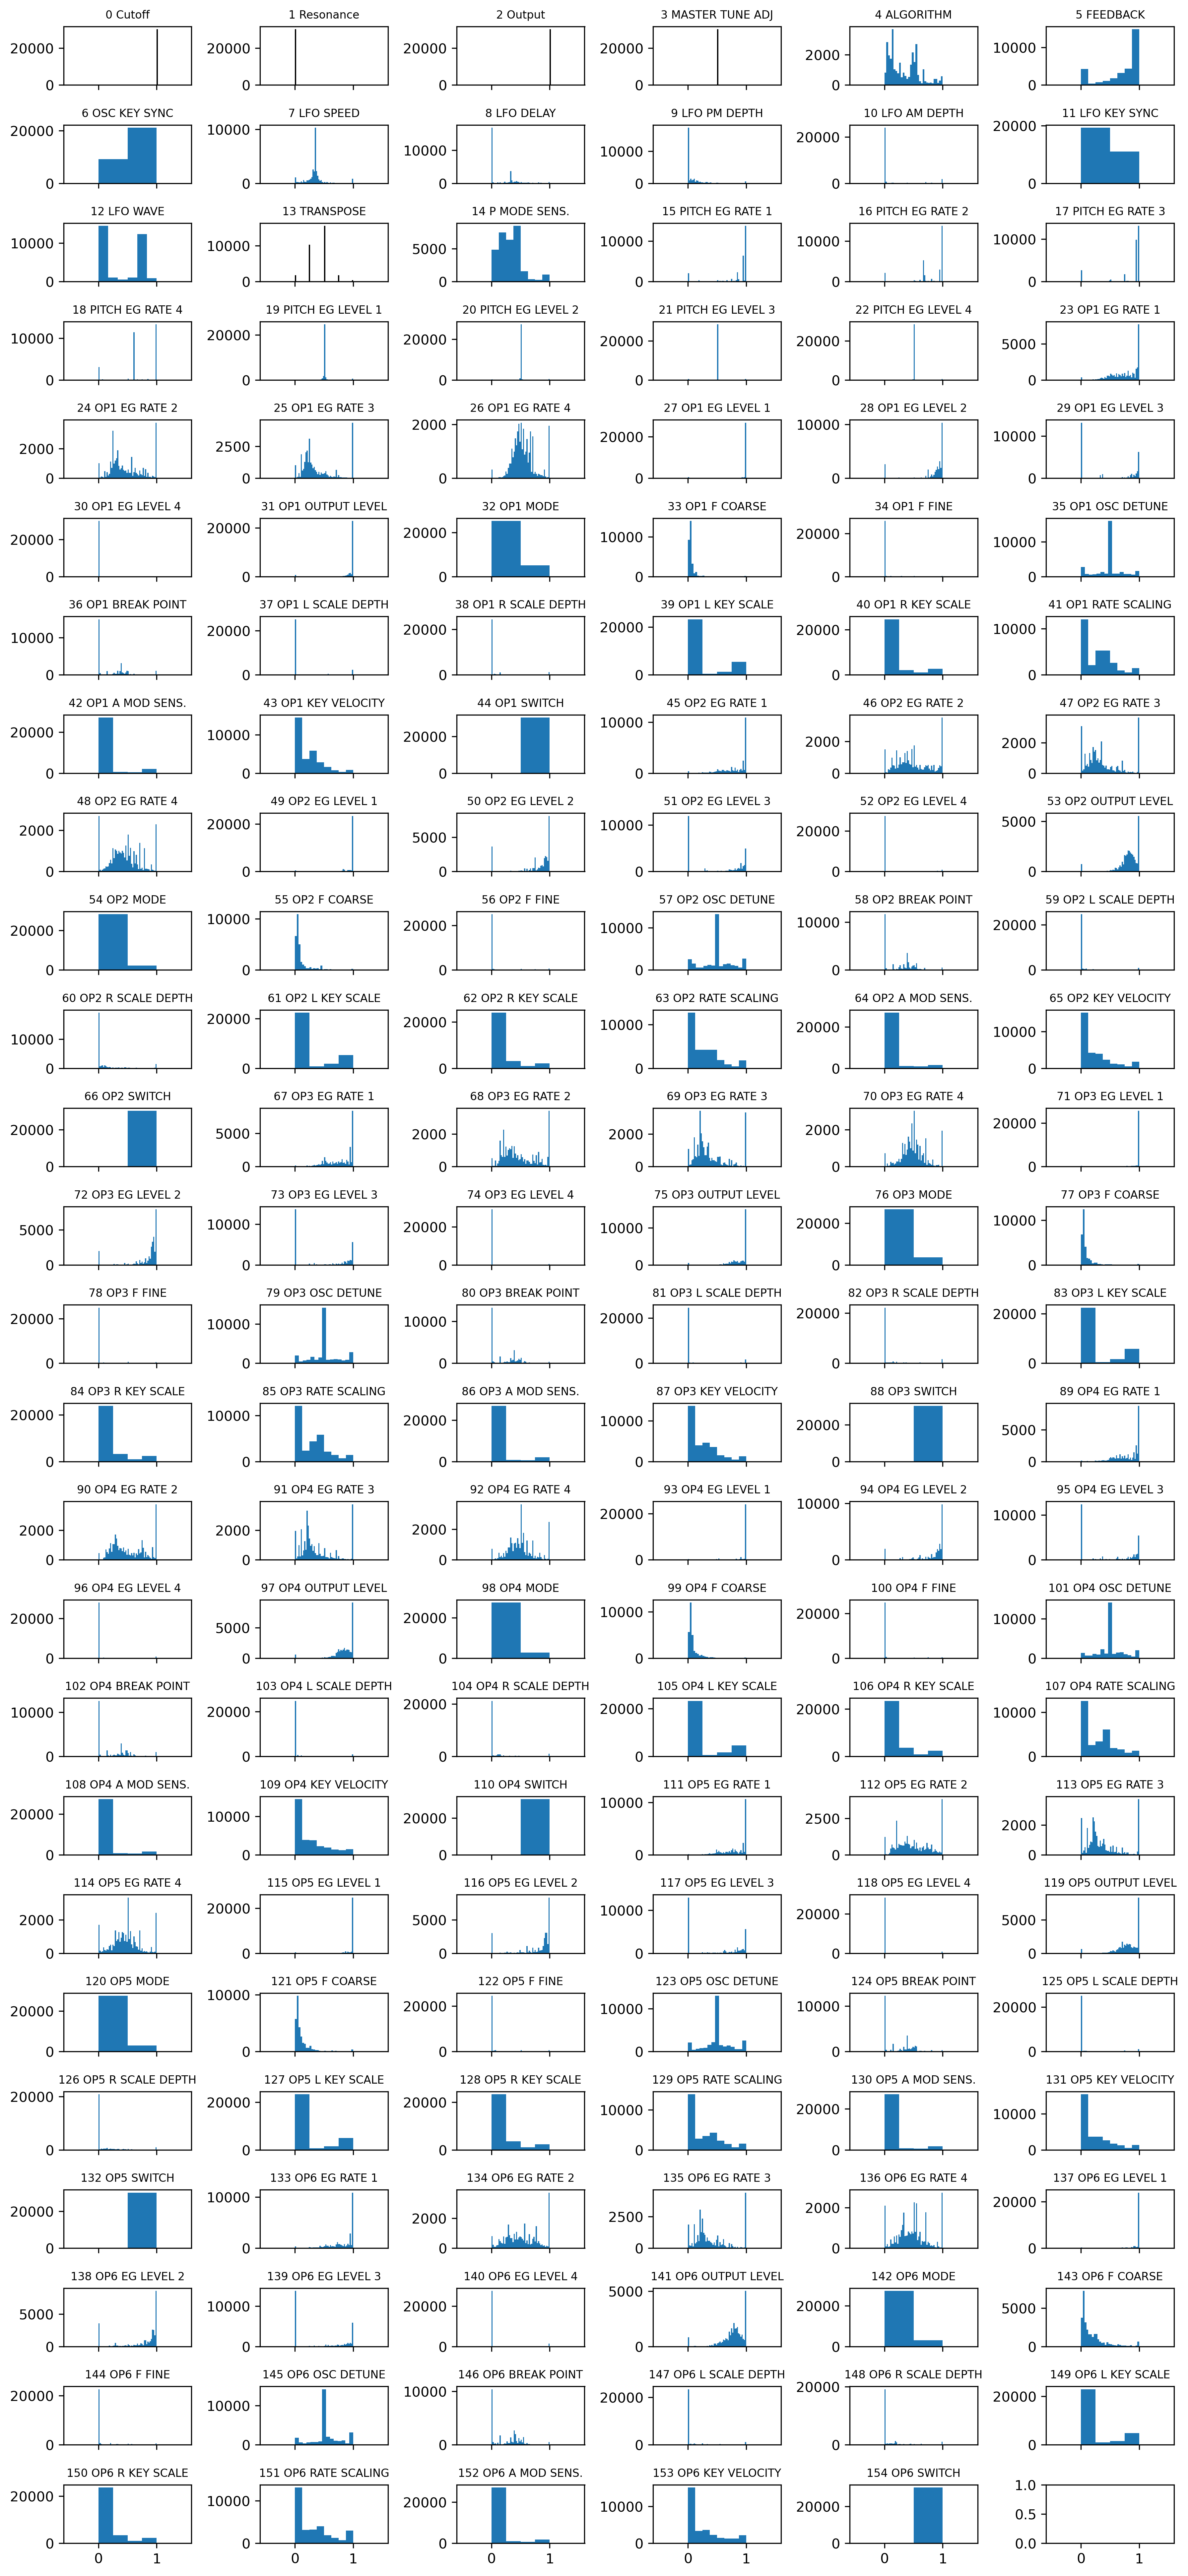

In [3]:
params_to_lock = [0, 1, 2, 3, 13]

# Histogrammes de *tous* les paramètres, pour voir ceux qu'on peut éventuellement virer
param_names = dexed_preset_db.get_param_names()
presets_mat = dexed_preset_db.presets_mat
print("{} free params, {} params should be locked".format(presets_mat.shape[1] - len(params_to_lock), len(params_to_lock)))
n_cols = 6
n_rows = 1 + presets_mat.shape[1] // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 1.0), sharex=True)
for i in range(presets_mat.shape[1]):
    param_values = presets_mat[:, i]
    col = i % n_cols
    row = i // n_cols
    # Custom bins for discrete params
    param_cardinality = dexed_renderer.get_param_cardinality(i)
    if param_cardinality > 0:
        bins = [float(i) / param_cardinality for i in range(param_cardinality+1)]
    else:
        bins = 50
    if i in params_to_lock:
        color = 'k'
    else:
        color = 'C0'
    axes[row, col].hist(param_values, bins=bins, fc=color)
    #axes[row, col].set_xlim([-0.1, 1.1])
    axes[row, col].set_title("{} {}".format(i, param_names[i]), fontsize=8)
fig.tight_layout()

### Paramètres fixes
* Les OP Switch sont toujours à ON

### Paramètres à verrouiller
* 13 transpose (middle C) devrait rester à sa valeur centrale. Pas besoin d'aller perturber tout le pitch
* 0, 1, 2, 3 (params généraux de filtre et de volume) peuvent aussi toujours rester à leurs valeur de défaut

### Paramètres qui risquent de poser problème
* Tous les params liés à la key (si 1 seule note pour tout le NN...)

In [4]:
# Infos sur les paramètres potentiellement inutilisés
for i in range(6):  # synthés qui ont 1 des 6 oscillateurs éteint ?
    opx_switch_values = presets_mat[:, 44 + 22 * i]
    print("OP{} est OFF pour {} preset(s)".format(i+1, opx_switch_values[np.where(opx_switch_values < 0.5)].shape[0]))

OP1 est OFF pour 0 preset(s)
OP2 est OFF pour 0 preset(s)
OP3 est OFF pour 0 preset(s)
OP4 est OFF pour 0 preset(s)
OP5 est OFF pour 0 preset(s)
OP6 est OFF pour 0 preset(s)


In [5]:
# Répartition des algorithmes
preset_algos = presets_mat[:, 4]
preset_algos = np.asarray(np.round(1.0 + preset_algos * 31.0), dtype=np.int)
fig, ax = plt.subplots(1, 1, figsize=(9, 2))
ax.hist(preset_algos, bins=[0.5 + i for i in range(33)], ec='k')
_ = ax.set_title("Histogramme des algorithmes utilisés pour l'ensemble des presets")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Dexed-generated wav file


In [6]:
importlib.reload(data.dataset)
importlib.reload(dexed)

limited_preset_indexes = dexed_preset_db.get_preset_indexes_for_algorithm(5)

def render_and_plot_audio(preset_idx, load_pre_rendered_wav=False):
    midi_note = 60
    midi_vel = 100
    #idx = preset_indexes[1363]
    idx = preset_idx
    if not load_pre_rendered_wav:
        # Nouvelle instance de dx7 à chaque nouveau rendu (pour éviter hanging notes...)
        dexed_renderer = dexed.Dexed()

        preset = dexed_preset_db.get_preset_values(idx, plugin_format=True)
        dexed_renderer.assign_preset(preset)
        dexed_renderer.set_default_general_filter_and_tune_params()
        dexed_renderer.set_all_oscillators_on()
        dexed_renderer.prevent_SH_LFO()
        audio = dexed_renderer.render_note(midi_note, midi_vel, normalize=False)  # 60: . 32: E3
        #print(dexed_renderer.current_preset[12])

        Fs = dexed_renderer.Fs
    else:
        audio, Fs = data.dataset.DexedDataset.get_wav_file(get_preset_UID(idx), midi_note, midi_vel)
    t = np.linspace(0.0, len(audio)/Fs, num=len(audio), endpoint=True)
    fig, axes = plt.subplots(2, 1, figsize=(9, 4))
    axes[0].plot(t, audio)
    axes[0].set_title("Preset {} (uid={}) '{}' (algo {})".format(idx, get_preset_UID(idx),
                                                        dexed_preset_db.get_preset_name(idx),
                                                        dexed_preset_db._preset_algos[idx]))
    rms = librosa.feature.rms(y=audio)
    times = librosa.times_like(rms)
    axes[1].semilogy(times, rms[0], label='RMS Energy (max {:.3f})'.format(rms[0].max()))
    axes[1].legend()
    
    return audio, Fs, rms[0].max()

audio, Fs, _ = render_and_plot_audio(1144)
Audio(audio, rate=Fs)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
if False:
    # Recherche de tous les presets à volume de sortie trop faible - lecture depuis .wav pré-rendus
    rms_energies = list()
    low_amplitude_indexes = list()

    for idx in range(presets_mat.shape[0]):
        audio, Fs = soundfile.read(data.dataset.DexedDataset.get_wav_file_path(get_preset_UID(idx), 60, 100))

        rms_energies.append(librosa.feature.rms(y=audio)[0].max())
        if rms_energies[-1] < 0.03:  # -30dB
            low_amplitude_indexes.append(idx)

        if idx%5000 == 0:
            print("Preset {}/{}".format(idx, presets_mat.shape[0]))

    print("{} low-energy presets".format(len(low_amplitude_indexes)))
    # histrogramme des RMS ENERGY
    fig, ax = plt.subplots(1, 1)
    ax.hist(rms_energies, bins=200)
    ax.set(title="Répartition des énergies RMS max. pour l'ensemble des presets")

    print(low_amplitude_indexes)

In [8]:
# !!! DANGER ZONE !!!
if False:
    import sqlite3

    # Deletion of low-RMS presets
    low_amplitude_preset_UIDs = dexed_preset_db.all_presets_df.iloc[low_amplitude_indexes]['index_preset'].values
    #print(low_amplitude_preset_UIDs)
    conn = sqlite3.connect('./synth/dexed_presets.sqlite', detect_types=sqlite3.PARSE_DECLTYPES)
    cur = conn.cursor()
    for uid in low_amplitude_preset_UIDs:
        # Cursor treated as an iterator over results. execute(...) requires the int to be re-casted....
        #for row in cur.execute("SELECT * FROM preset WHERE index_preset=?", (int(uid),)):
        #    print(row)
        #cur.execute("DELETE FROM preset WHERE index_preset=?", (int(uid),))  # Un-comment to re-activate deletion
        pass
    conn.commit()
    conn.close()

---

# Random preset - visualization of audio and parameters


In [9]:
# Using the dataset
import config
importlib.reload(config)  # Warning: config might reduced algorithms and/or operators used. Check config.py
import data.build
importlib.reload(data.build)
import data.dataset
importlib.reload(data.dataset)

full_dataset, dataset = data.build.get_full_and_split_datasets(config.model, config.train)
print(full_dataset)

Dataset of 2728/30293 Dexed presets. 122 learnable synth params, 33 fixed params. Mel Spectrogram items, size=torch.Size([1, 257, 347]), min=-120.0dB, normalization:min_max. Restricted to labels: ('harmonic',). Enabled operators: [1, 2, 3, 4, 5]


In [10]:
dataset_index = 46   # 46, 357
#dataset_index = np.random.randint(len(full_dataset))
x_in, u_in, sample_info, labels = full_dataset[dataset_index]
preset_UID, midi_note, midi_velocity = sample_info[0].item(), sample_info[1].item(), sample_info[2].item()
print("Preset UID = {} (dataset index {})".format(preset_UID, dataset_index))

preset_params = full_dataset.get_preset_params(preset_UID)
x_wav, Fs = full_dataset._render_audio(preset_params, midi_note, midi_velocity)

Audio(x_wav, rate=Fs, normalize=True)

Preset UID = 1290 (dataset index 46)


In [11]:
# - - - - - params visualization - - - - -
import utils.figures
importlib.reload(utils.figures)

# Dummy inferred - for tests
inferred_params = None  #np.asarray(preset_params) * 0.8 + 0.1
utils.figures.plot_synth_preset_param(preset_params, inferred_params, preset_UID=preset_UID,
                                      param_names=full_dataset.preset_param_names,
                                      learnable_param_indexes=full_dataset.learnable_params_idx, synth_name="Dexed")


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(<Figure size 2015x400 with 1 Axes>,
 [<AxesSubplot:title={'center':'Preset UID=1290'}, ylabel='Param. value'>])

---
## Corrupted presets removal and/or processing
DB check: some parameters were > 1.0. Probably comes from non-DX7 or corrupted .sys cartridges, read by Dexed without triggering errors.

In [12]:
presets_mat = dexed_preset_db.presets_mat
corrupted_indexes = []
corrupted_labels = {'harmonic': 0, 'percussive': 0, 'sfx': 0}
for i in range(presets_mat.shape[0]):
    if presets_mat[i, :].min() < 0.0 or presets_mat[i, :].max() > 1.0:
        corrupted_indexes.append(i)
        labels = dexed_preset_db.get_preset_labels_from_file(dexed_preset_db.all_presets_df.iloc[i]['index_preset'])
        for k in corrupted_labels:
            for l in labels:
                if l==k:
                    corrupted_labels[k] += 1
print("{} corrupted (min/max) presets".format(len(corrupted_indexes)))
print(corrupted_labels)
corrupted_preset_i = 0  # listening stopped at 117

0 corrupted (min/max) presets
{'harmonic': 0, 'percussive': 0, 'sfx': 0}


In [13]:
# Listening results
corrupted_preset_UIDs_to_remove = []
should_be_percussive_UIDs = [28]
should_be_sfx_UIDs = [343, 435]
bizarre_release_UIDs = [351, 436, 571]

In [14]:
importlib.reload(utils.figures)

print_and_plot = False

if len(corrupted_indexes) > 0:
    fatal_corruption = False
    while not fatal_corruption:
        preset_index = corrupted_indexes[corrupted_preset_i]
        #preset_index = corrupted_indexes[np.random.randint(0, len(corrupted_indexes))]
        preset_UID = dexed_preset_db.all_presets_df.iloc[preset_index]['index_preset']
        # Audio sample: corrupted preset (with corrected value)
        corrupted_preset = presets_mat[preset_index, :]
        clamped_preset = np.minimum(corrupted_preset, np.ones(corrupted_preset.shape))
        #x_wav, Fs = data.dataset.DexedDataset.get_wav_file(preset_UID, 60, 100)
        dexed_renderer = dexed.Dexed()
        dexed_renderer.assign_preset(dexed.PresetDatabase.get_params_in_plugin_format(clamped_preset))
        Fs = dexed_renderer.Fs
        x_wav = dexed_renderer.render_note(60, 100)

        # Fatal corruption detection: no-release preset. These parameters should always be 0.0...
        OPx_EG_LEVEL_4_indexes = [30, 52, 74, 96, 118, 140]
        fatal_corruption = False
        for idx in OPx_EG_LEVEL_4_indexes:
            if corrupted_preset[idx] > 1.0:
                fatal_corruption = True
                break
        if fatal_corruption:
            print("***** EG 'Release level' param is corrupted")
        if print_and_plot or fatal_corruption:
            print("i={}".format(corrupted_preset_i))
            print("Corrupted example: index={} UID={}".format(preset_index, preset_UID))
            print(dexed_preset_db.get_preset_labels_from_file(preset_UID))
            utils.figures.plot_synth_preset_param(corrupted_preset, clamped_preset, preset_UID=preset_UID, param_names=dexed_preset_db.get_param_names())

        corrupted_preset_i += 1

    Audio(x_wav, rate=Fs)

In [15]:
# Clamping of corrupted preset values. Listening seem to show that clamped corrupted presets sound good... No absurd sound observed
import sqlite3
import copy
# =====================================
# ==== DANGER ZONE - SQLite modif =====
# =====================================
print("{} corrupted (min/max) presets".format(len(corrupted_indexes)))

conn = sqlite3.connect('./synth/dexed_presets.sqlite', detect_types=sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()
for i in range(len(corrupted_indexes)):
    preset_index = corrupted_indexes[i]
    preset_UID = dexed_preset_db.all_presets_df.iloc[preset_index]['index_preset']
    corrupted_preset = copy.deepcopy(presets_mat[preset_index, :])
    if preset_UID == 74:
        print(corrupted_preset[52])
    # Before clamping: any EG 4 LEVEL corrupted value will be set to zero
    info = 'clamped'
    OPx_EG_LEVEL_4_indexes = [30, 52, 74, 96, 118, 140]
    opx_corrupted = []
    for i, idx in enumerate(OPx_EG_LEVEL_4_indexes):
        if corrupted_preset[idx] > 1.0:
            corrupted_preset[idx] = 0.0
            opx_corrupted.append(i)
    if len(opx_corrupted) > 0:
        info += ',op'
        for opx_i in opx_corrupted:
            info += '{}'.format(opx_i + 1)
        info += '_eglvl4_0.0'
    clamped_preset = np.minimum(corrupted_preset, np.ones(corrupted_preset.shape))  # auto-cast to float64?
    # Ensure float32 type before writing to db
    clamped_preset = np.asarray(clamped_preset, dtype=np.float32)
    if False:  # Write to DB
        #cur.execute("UPDATE preset SET pickled_params_np_array=?, info=? WHERE index_preset=?;", (clamped_preset, info, preset_UID))
        # Mixed Python string format and cursor execute args...
        cur.execute("UPDATE preset SET pickled_params_np_array=?, info='{}' WHERE index_preset={}".format(info, preset_UID), (clamped_preset,))

# Dummy DB test...
#cur.execute("UPDATE preset SET info='plop' WHERE index_preset=0")  # OK...
        
conn.commit()
conn.close()

0 corrupted (min/max) presets


---
# TODO Listening tests - reduced operators count

In [16]:
# Using the dataset
import config
importlib.reload(config)
import data.build
importlib.reload(data.build)
import data.dataset
importlib.reload(data.dataset)

# Select operators here
config.model.dataset_synth_args = ([2], [1, 2])

full_dataset, dataset = data.build.get_full_and_split_datasets(config.model, config.train)
print(full_dataset)

[PresetDataset] Cannot open '/home/gwendal/Jupyter/nn-synth-interp/data/stats/DexedDataset_spectrogram_nfft1024hop0256mels0257_op12.json' stats file.
[PresetDataset] No pre-computed spectrogram stats can be found. No normalization will be performed


RuntimeError: [data/dataset.py] Can't open file /home/gwendal/Jupyter/nn-synth-interp/synth/dexed_presets/preset000007_midi060vel100_op12.wav. Please pre-render audio files for this dataset configuration.

In [ ]:
dataset_index = 60
x_in, u_in, sample_info, labels = full_dataset[dataset_index]
preset_UID, midi_note, midi_velocity = sample_info[0].item(), sample_info[1].item(), sample_info[2].item()
print("Preset UID = {}".format(preset_UID))

preset_params = full_dataset.get_preset_params(preset_UID)
x_wav, Fs = full_dataset._render_audio(preset_params, midi_note, midi_velocity)

utils.figures.plot_synth_preset_param(preset_params, preset_UID=preset_UID,
                                      param_names=full_dataset.preset_param_names,
                                      learnable_param_indexes=full_dataset.learnable_params_idx, synth_name="Dexed")

Audio(x_wav, rate=Fs, normalize=True)